In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
PATH = '/kaggle/input/utkface-new/crop_part1/'
images = []
ages = []
genders = []

for i in os.listdir(PATH)[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open(PATH + i))

In [3]:
images = pd.Series(list(images), name = 'img')
ages = pd.Series(list(ages), name = 'age')
genders = pd.Series(list(genders), name = 'gen')

df = pd.concat([images, ages, genders], axis=1)
df

,img,age,gen
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,21,1
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,17,1
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,76,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,18,1
...,...,...,...
7995,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3,0
7996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,28,0
7997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,10,0
7998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,8,1


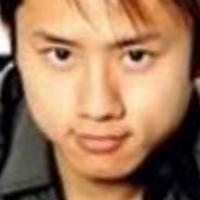

26 0


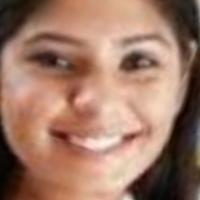

21 1


In [4]:
display(df['img'][0])
print(df['age'][0], df['gen'][0])
display(df['img'][1])
print(df['age'][1], df['gen'][1])

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='age', ylabel='Count'>

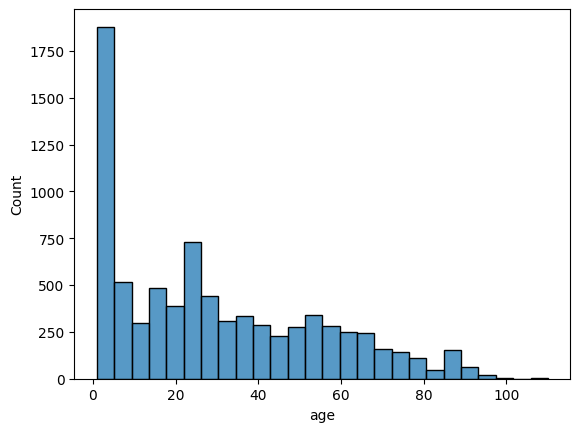

In [5]:
sns.histplot(data=df, x='age')

## normalize

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


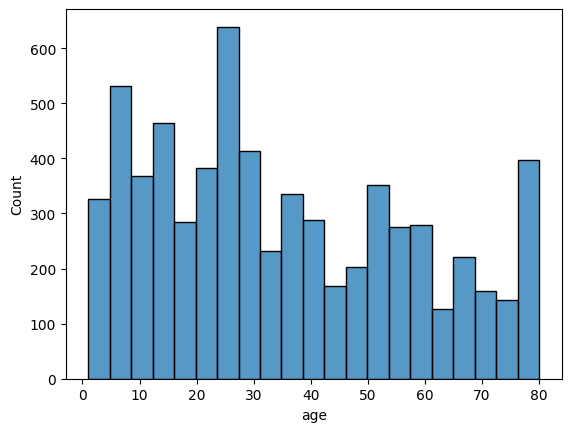

In [6]:
df.loc[df['age'] > 80, 'age'] = 80


under_4 = df[df['age'] < 4]

sampled_under_4 = under_4.sample(n=int(df['age'].mean() * 4), random_state=42)

over_or_equal_4 = df[df['age'] >= 4]

final_df = pd.concat([sampled_under_4, over_or_equal_4])
sns.histplot(data=final_df, x='age')

In [7]:
final_df

,img,age,gen
7007,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2,0
462,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3,1
5227,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2,1
3657,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,0
5878,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,1
...,...,...,...
7994,<PIL.JpegImagePlugin.JpegImageFile image mode=...,22,1
7996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,28,0
7997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,10,0
7998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,8,1


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='gen', ylabel='Count'>

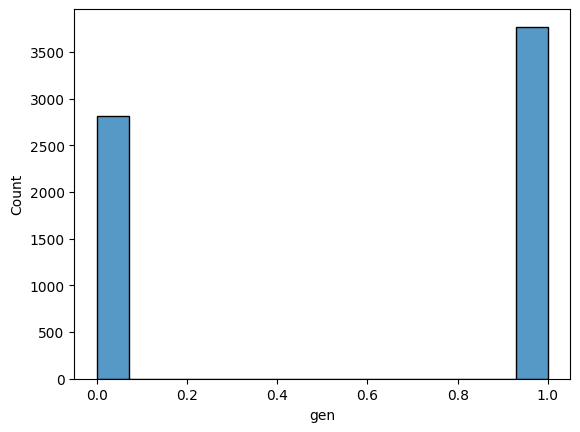

In [8]:
sns.histplot(final_df['gen'])

## load img

In [9]:
df = final_df

In [10]:
X_images = np.array([np.array(img)/256 for img in df['img']])
y_age = df['age'].values
y_gender = df['gen'].values

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

def preprocess_data(image, outputs):
    image = tf.cast(image, tf.float32) / 255.0
    return image, outputs


X_train, X_test, y_age_train, y_age_test, y_gen_train, y_gen_test = train_test_split(
    X_images,
    y_age,
    y_gender,
    test_size=0.2
)

train_outputs = {'age': y_age_train, 'gen': y_gen_train}
train_ds = tf.data.Dataset.from_tensor_slices((X_train, train_outputs))
train_ds = (
    train_ds.shuffle(len(X_train))
    .map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

test_outputs = {'age': y_age_test, 'gen': y_gen_test}
test_ds = tf.data.Dataset.from_tensor_slices((X_test, test_outputs))
test_ds = (
    test_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

I0000 00:00:1754421996.099731     128 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [24]:
import tensorflow.keras.applications

base_model = tensorflow.keras.applications.ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_shape=(200,200,3),
    name="resnet152v2"
)

x = base_model.output
x = GlobalAveragePooling2D()(x) 
x_age = Dense(1024, activation='relu')(x) 
x_age = Dropout(0.5)(x_age)
x_age = Dense(1, activation='relu', name='age')(x_age)

x_gen = Dense(1024, activation='relu')(x) 
x_gen = Dropout(0.5)(x_gen)
x_gen = Dense(1, activation='sigmoid', name='gen')(x_gen)

model = Model(inputs=base_model.input, outputs=[x_age, x_gen])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 206, 206,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 100,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 102, 102,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 50, 50,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 50, 50,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 50, 50,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 50,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 50,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 52, 52,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 50,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 50, 50,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 50, 50,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 50, 50,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 50, 50,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 50, 50,    │          0 │ conv2_block1_0_c

 Total params: 62,530,050 (238.53 MB)

 Trainable params: 62,386,306 (237.98 MB)

 Non-trainable params: 143,744 (561.50 KB)

In [25]:
base_model.trainable = False
model.compile(
    optimizer='adam',
    loss={
        'age': 'mae',
        'gen': 'binary_crossentropy'
    },
    metrics={
        'age': 'mae',
        'gen': 'accuracy'
    }
)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 206, 206,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 100,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 102, 102,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 50, 50,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 50, 50,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 50, 50,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 50,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 50,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 52, 52,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 50,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 50, 50,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 50, 50,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 50, 50,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 50, 50,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 50, 50,    │          0 │ conv2_block1_0_c

 Total params: 62,530,050 (238.53 MB)

 Trainable params: 4,198,402 (16.02 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [27]:
history = model.fit(train_ds, epochs=20, validation_data=test_ds)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - age_loss: 17.3079 - age_mae: 17.3079 - gen_accuracy: 0.6676 - gen_loss: 0.6050 - loss: 17.9129 - val_age_loss: 16.2753 - val_age_mae: 16.1233 - val_gen_accuracy: 0.7398 - val_gen_loss: 0.5711 - val_loss: 16.6950
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - age_loss: 16.9315 - age_mae: 16.9315 - gen_accuracy: 0.6817 - gen_loss: 0.5911 - loss: 17.5227 - val_age_loss: 16.1462 - val_age_mae: 15.9897 - val_gen_accuracy: 0.7451 - val_gen_loss: 0.5765 - val_loss: 16.5658
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - age_loss: 16.4342 - age_mae: 16.4343 - gen_accuracy: 0.6797 - gen_loss: 0.5932 - loss: 17.0275 - val_age_loss: 15.8299 - val_age_mae: 15.7032 - val_gen_accuracy: 0.7428 - val_gen_loss: 0.5717 - val_loss: 16.2743
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - age_loss: 16.2832 - age_mae: 16.2833 - gen_accuracy: 0.6987 - gen_loss: 0.5845 - loss: 16.8678 - val_age_loss: 15.9339 - val_age_mae: 15